In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import pprint

%matplotlib inline
pp = pprint.PrettyPrinter(indent=4).pprint

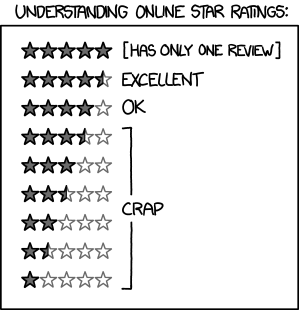

In [12]:
#https://xkcd.com/1098/
url = 'https://imgs.xkcd.com/comics/star_ratings.png'
    
from IPython.display import Image                        
Image(url,width=300, height=300)

### Get ratings data for all restaurant reviews

Get two sets of data: all users reviews and elite user reviews.
    
The supposition here is that elite users could be better than normal users in two ways:
1. They may have a more normal rating distribution.
2. Their reviews many be (overall) better quality.

In [2]:
conn = psycopg2.connect('dbname=yelp user=tlappas host=/var/run/postgresql')
cur = conn.cursor()

cur.execute("""
    select business.name, review.stars, review.review_text, user_info.user_id, user_info.elite 
    from review, business, user_info
    where review.user_id = user_info.user_id
    and business.business_id = review.business_id
    and business.categories LIKE '%Restaurants%'
""")

all_reviews = pd.DataFrame(cur.fetchall(), columns=['name', 'stars', 'text', 'user_id', 'elite'])

cur.execute("""
    select business.name, review.stars, review.review_text, user_info.user_id, user_info.elite 
    from review, business, user_info
    where review.user_id = user_info.user_id
    and business.business_id = review.business_id
    and business.categories LIKE '%Restaurants%'
    and length(user_info.elite) != 0 
""")

elite_reviews = pd.DataFrame(cur.fetchall(), columns=['name', 'stars', 'text', 'user_id', 'elite'])

### Compare Total Reviews: All Users vs Elite Users

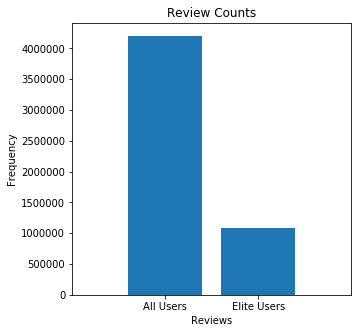

In [13]:
hist_data = [len(all_reviews), len(elite_reviews)]

fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.set(xlabel='Reviews', ylabel='Frequency')
ax.set(title='Review Counts')
ax.set(xticks=[1,2], xticklabels=['All Users','Elite Users'])
ax.set(xlim=[0,len(hist_data)+1])
ax.bar(range(1,len(hist_data)+1), hist_data, width=0.8, align='center')

plt.show()

### Plot Review Histograms

Imbalanced categories are an issue in the review dataset. Exploring combinations of the star ratings for all users and elite users.

Seems reasonable to combine star ratings into groups for classification.

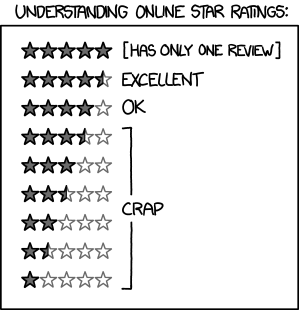

In [14]:
#https://xkcd.com/1098/
url = 'https://imgs.xkcd.com/comics/star_ratings.png'
    
from IPython.display import Image                        
Image(url,width=300, height=300)

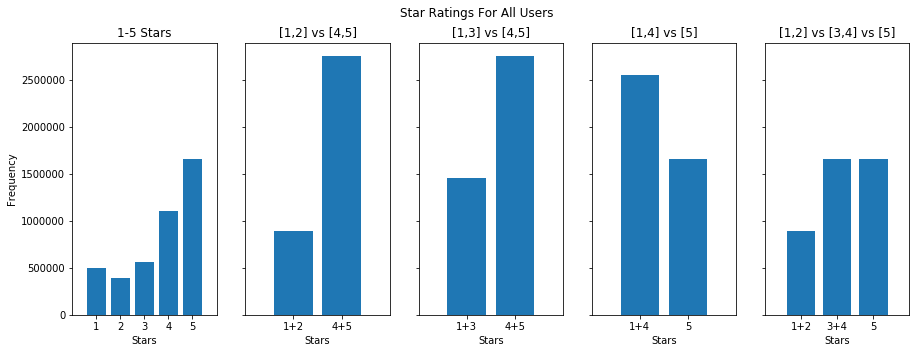

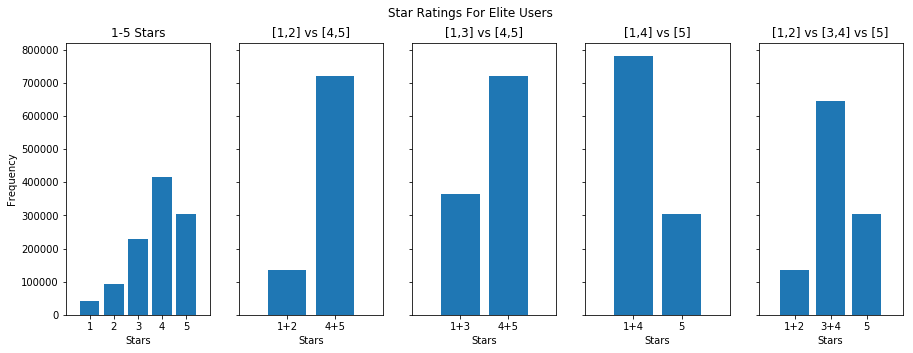

In [8]:
# Starting at 1 to cut off the dataframe row index
# Indexing from 1 to end to remove the 0 bin
all_counts = np.bincount(all_reviews.loc[1:,'stars'])[1:]
elite_counts = np.bincount(elite_reviews.loc[1:,'stars'])[1:]

# bincount returns a list of max value + 1. If there's no 5 star rating length with be 4. Etc.
all_counts = np.append(all_counts, ([0] * (5 - len(all_counts))))
elite_counts = np.append(elite_counts, ([0] * (5 - len(elite_counts))))

fig_titles = ['Star Ratings For All Users','Star Ratings For Elite Users']
plot_titles = ['1-5 Stars', '[1,2] vs [4,5]', '[1,3] vs [4,5]', '[1,4] vs [5]', '[1,2] vs [3,4] vs [5]']
tick_labels = [
    ['1', '2', '3', '4', '5'],
    ['1+2','4+5'],
    ['1+3','4+5'],
    ['1+4','5'],
    ['1+2','3+4','5']
]
datasets = [all_counts, elite_counts]

for i, data in enumerate(datasets):

    fig, ax = plt.subplots(1,len(data), sharey='row', figsize=(3*len(data),5))
    fig.suptitle(fig_titles[i])
    
    rating_combos = [
        data, 
        [sum(data[:2]), sum(data[3:])], 
        [sum(data[:3]), sum(data[3:])], 
        [sum(data[:4]), data[4]], 
        [sum(data[:2]), sum(data[2:4]), data[4]]
    ]
    
    for j, hist_data in enumerate(rating_combos):
                 
        # Set universal attributes
        for k in range(ax.shape[0]):
            ax[k].set(xlabel='Stars')
    
        # Special behavior for first graph
        if j == 0:
            ax[j].set(ylabel='Frequency')
    
        # Plot
        ax[j].set(title=plot_titles[j])
        ax[j].set(xlim=[0,len(hist_data)+1])
        ax[j].set(xticks=range(1,len(hist_data)+1), xticklabels=tick_labels[j])
        ax[j].bar(range(1,len(hist_data)+1), hist_data, width=0.8, align='center')

### Review Length

Plot the review length (in characters) for all users and elite users. Review lengths are all between 1 and 5000 characters. Bin width is 50.

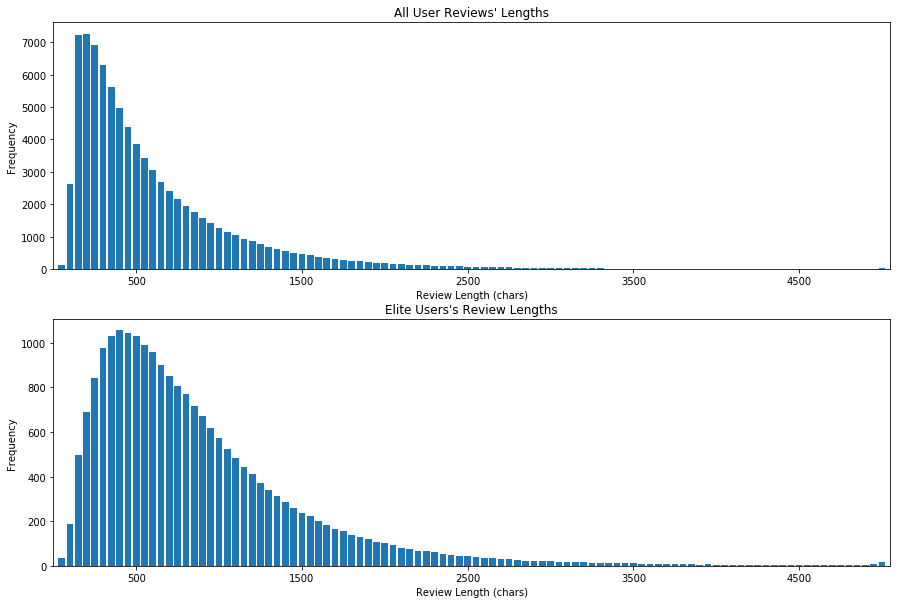

In [7]:
all_reviews_length = [len(review) for review in all_reviews.loc[1:, 'text']]
elite_reviews_length = [len(review) for review in elite_reviews.loc[1:, 'text']]

all_hist = np.bincount(np.append(all_reviews_length, [5000]))
elite_hist = np.bincount(np.append(elite_reviews_length, [5000]))
                         
all_hist[-1] -= 1
elite_hist[-1] -= 1

fig, ax = plt.subplots(2, 1, figsize=(15,10))
length_data = [all_hist[1:], elite_hist[1:]]
plot_titles = ['All User Reviews\' Lengths', 'Elite Users\'s Review Lengths']
                         
for i, hist_data in enumerate(length_data):
                        
    # Each array has 5000 bins, which is way more than necessary
    # Downsample to 100
    hist_data = hist_data.reshape(-1, 50).mean(axis=1)

    # Set universal attributes
    for k in range(ax.shape[0]):
        ax[k].set(xlabel='Review Length (chars)', ylabel='Frequency')

    # Plot
    ax[i].set(title=plot_titles[i])
    ax[i].set(xticks=[10, 30, 50, 70, 90], xticklabels=['500','1500','2500','3500','4500'])
    ax[i].set(xlim=[0,len(hist_data)+1])
    ax[i].bar(range(1,len(hist_data)+1), hist_data, width=0.8, align='center')
    
plt.show()